In [12]:
#pylint: disable=wrong-import-position
# pylint: disable=no-member
!pip install download
from datetime import datetime
import sys
import matplotlib.pyplot as plt # type: ignore
import pandas as pd # type: ignore
sys.path.append("./Methods")
plt.style.use('seaborn')
#pylint: disable=wrong-import-position
#from download import download_file #pylint: disable=wrong-import-position
#from emission import add_emission #pylint: disable=wrong-import-position
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm
import numpy as np
import itertools
from sklearn.metrics import mean_squared_error
import warnings
import os
import urllib.request
import pandas as pd
import seaborn as sns

/var/folders/vn/7p3t4_3n02gcv591cgws1gw80000gn/T/ipykernel_1401/2897355045.py:9: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


In [13]:
class Agros_class:
    def __init__(self):
        '''
        Init method of the class EnergyClass
        Parameters
        nothing
        ------------
        Returns
        nothing
        ---------
        '''
        self.data = None
        self.file = False
        self.download_file()
        self.read_data()

    def download_file(self):
        '''
        Download data file into downloads/ directory
        Parameters
        nothing
        ------------
        Returns
        nothing
        ---------
        '''
        url = "https://raw.githubusercontent.com/owid/owid-datasets/master/datasets/Agricultural%20total%20factor%20productivity%20(USDA)/Agricultural%20total%20factor%20productivity%20(USDA).csv"
        file_path = "downloads/data_file.csv"
        
        if not os.path.exists("downloads"):
            os.makedirs("downloads")
        
        if os.path.exists(file_path):
            print("File already exists, skipping download")
        else:
            print("Downloading file from URL...")
            urllib.request.urlretrieve(url, file_path)
            print("File downloaded successfully")
        
        self.file = True

    def read_data(self):
        '''
        Read data file into a Pandas DataFrame
        Parameters
        nothing
        ------------
        Returns
        nothing
        ---------
        '''
        file_path = "downloads/data_file.csv"
        if os.path.exists(file_path):
            self.data = pd.read_csv(file_path)
            print("Data loaded successfully into a Pandas DataFrame")
        else:
            print("Data file not found")

    def get_countries(self):
        '''
        Get a list of the available countries in the data set
        Parameters
        nothing
        ------------
        Returns
        A list of the available countries in the data set
        ---------
        '''
        if self.data is not None:
            return list(self.data['Entity'].unique())
        else:
            print("Data not loaded yet")
    
    def plot_quantity_correlation(self):
        '''
        Plot a correlation matrix between the "_quantity" columns in the dataset
        Parameters
        ----------
        nothing
        ------------
        Returns
        ----------
        nothing
        '''
        if self.data is not None:
            # Select only columns that contain "_quantity"
            quantity_cols = [col for col in self.data.columns if '_quantity' in col]
            # Compute correlation matrix
            corr = self.data[quantity_cols].corr()
            # Plot heatmap of correlation matrix
            sns.heatmap(corr, annot=True, cmap='coolwarm')
            plt.show()
        else:
            print("Data not loaded yet")
    
    def plot_output_area_chart(self, country=None, normalize=False):
        '''
        Plot an area chart of the distinct "_output_" columns.
        '''
        if self.data is None:
            print("Data not loaded yet")
            return

        if country is None or country == 'World':
            data_to_plot = self.data.groupby('Year').sum().loc[:, 'ag_land_quantity':'irrigation_quantity']
        else:
            if country not in self.get_countries():
                raise ValueError(f"{country} does not exist in the dataset")

            data_to_plot = self.data[self.data['Entity'] == country].set_index('Year').loc[:, 'ag_land_quantity':'irrigation_quantity']

        if normalize:
            data_to_plot = data_to_plot.divide(data_to_plot.sum(axis=1), axis=0) * 100
            
        data_to_plot.plot.area()
        plt.xlabel("Year")
        plt.ylabel("Output")
        plt.title(f"{'World' if country is None else country} Output{' (Normalized)' if normalize else ''}")
        plt.show()
    
    def compare_output_total(self, countries):
        '''
        Compare the total output of selected countries across years and plot it
        Parameters
        ----------
        countries : str or list
            The name of a country or a list of country names to compare
        ------------
        Returns
        ----------
        nothing
        '''
        if self.data is None:
            print("Data not loaded yet")
            return
        
        # Convert string to list if only one country is provided
        if isinstance(countries, str):
            countries = [countries]
        
        # Filter data for selected countries
        filtered_data = self.data[self.data['Entity'].isin(countries)]
        
        # Compute total output for each year
        data_to_plot = filtered_data.groupby('Year').sum().loc[:, 'output':'output_quantity']
        data_to_plot['Total'] = data_to_plot.sum(axis=1)
        
        # Plot total output over time for each country
        for country in countries:
            plt.plot(data_to_plot.index, filtered_data[filtered_data['Entity']==country]['output'], label=country)
        
        plt.plot(data_to_plot.index, data_to_plot['Total'], label='Total')
        plt.legend()
        plt.xlabel('Year')
        plt.ylabel('Output (US$)')
        plt.show()
    
    def gapminder(self, year):
        '''
        Plot a scatter plot comparing fertilizer_quantity and output_quantity for a given year
        The area of each dot represents a third relevant variable
        Parameters
        ----------
        year: int
        The year to plot the scatter plot for
        ------------
        Returns
        ----------
        nothing
        '''
        # Check if year is an integer
        if not isinstance(year, int):
            raise TypeError("Year must be an integer")
            
        # Filter data for given year
        data_filtered = self.data[self.data['Year'] == year]
            
        # Set area size based on a third relevant variable (here, 'land_area' column)
        area_size = data_filtered['ag_land_index']*10
        
        # Plot scatter plot
        plt.scatter(data_filtered['fertilizer_quantity'], data_filtered['output_quantity'], s=area_size, c=data_filtered['fertilizer_quantity'], cmap='Blues', alpha=0.4, edgecolors='grey', linewidth=2)

        # Set plot title and axis labels
        plt.title(f"Gapminder Plot for year {year}")
        plt.xlabel("Fertilizer Quantity")
        plt.ylabel("Output Quantity")
            
        # Show plot
        plt.show()



In [14]:
agros = Agros_class()

File already exists, skipping download
Data loaded successfully into a Pandas DataFrame


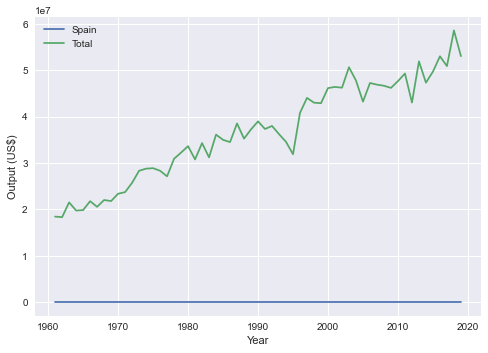

In [15]:
#Use the fifth method to illustrate each country chosen and point out the main differences.

agros.compare_output_total( "Spain")

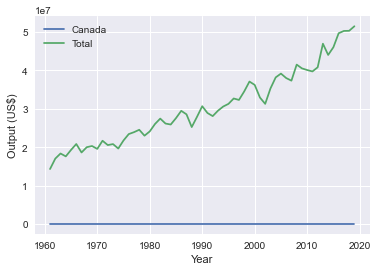

In [5]:
agros.compare_output_total( "Canada")

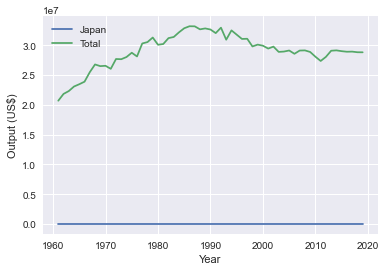

In [6]:
agros.compare_output_total("Japan")

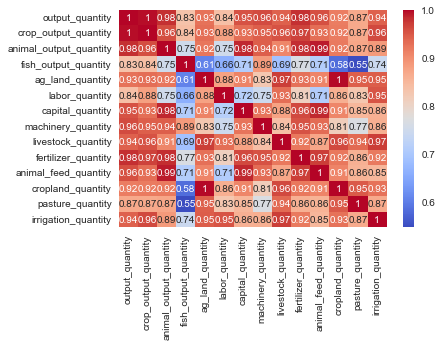

In [7]:
agros.plot_quantity_correlation()

In [ ]:
x. 